In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(463113, 828)
(463113, 1)
validation
(87055, 828)
(87055, 1)
test
(43409, 828)
(43409, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:14 - loss: 0.0149 - STD: 1.4231e-04 - MAE: 0.0870

 4/47 [=>............................] - ETA: 1s - loss: 0.0164 - STD: 2.1919e-04 - MAE: 0.0997  

 5/47 [==>...........................] - ETA: 1s - loss: 0.0167 - STD: 2.6334e-04 - MAE: 0.0989

 6/47 [==>...........................] - ETA: 1s - loss: 0.0169 - STD: 3.1162e-04 - MAE: 0.0985

 7/47 [===>..........................] - ETA: 1s - loss: 0.0167 - STD: 3.6990e-04 - MAE: 0.0969

 8/47 [====>.........................] - ETA: 1s - loss: 0.0161 - STD: 4.3914e-04 - MAE: 0.0949

 9/47 [====>.........................] - ETA: 1s - loss: 0.0157 - STD: 5.1845e-04 - MAE: 0.0941

10/47 [=====>........................] - ETA: 1s - loss: 0.0155 - STD: 6.0232e-04 - MAE: 0.0944

11/47 [======>.......................] - ETA: 1s - loss: 0.0154 - STD: 6.8653e-04 - MAE: 0.0952

12/47 [======>.......................] - ETA: 1s - loss: 0.0153 - STD: 7.6742e-04 - MAE: 0.0954

13/47 [=======>......................] - ETA: 1s - loss: 0.0150 - STD: 8.3917e-04 - MAE: 0.0951

14/47 [=======>......................] - ETA: 1s - loss: 0.0148 - STD: 9.0109e-04 - MAE: 0.0944

15/47 [========>.....................] - ETA: 1s - loss: 0.0147 - STD: 9.5618e-04 - MAE: 0.0936

16/47 [=========>....................] - ETA: 1s - loss: 0.0145 - STD: 0.0010 - MAE: 0.0929    

17/47 [=========>....................] - ETA: 1s - loss: 0.0144 - STD: 0.0011 - MAE: 0.0922

18/47 [==========>...................] - ETA: 1s - loss: 0.0144 - STD: 0.0011 - MAE: 0.0917

19/47 [===========>..................] - ETA: 1s - loss: 0.0143 - STD: 0.0012 - MAE: 0.0912

20/47 [===========>..................] - ETA: 1s - loss: 0.0142 - STD: 0.0012 - MAE: 0.0909

21/47 [============>.................] - ETA: 1s - loss: 0.0141 - STD: 0.0013 - MAE: 0.0906

22/47 [=============>................] - ETA: 1s - loss: 0.0140 - STD: 0.0014 - MAE: 0.0905

23/47 [=============>................] - ETA: 1s - loss: 0.0139 - STD: 0.0014 - MAE: 0.0905

24/47 [==============>...............] - ETA: 1s - loss: 0.0138 - STD: 0.0015 - MAE: 0.0905

25/47 [==============>...............] - ETA: 1s - loss: 0.0138 - STD: 0.0016 - MAE: 0.0905

26/47 [===============>..............] - ETA: 1s - loss: 0.0137 - STD: 0.0017 - MAE: 0.0903

27/47 [================>.............] - ETA: 1s - loss: 0.0136 - STD: 0.0017 - MAE: 0.0901

28/47 [================>.............] - ETA: 1s - loss: 0.0135 - STD: 0.0018 - MAE: 0.0898

29/47 [=================>............] - ETA: 1s - loss: 0.0135 - STD: 0.0019 - MAE: 0.0895

30/47 [==================>...........] - ETA: 1s - loss: 0.0134 - STD: 0.0020 - MAE: 0.0893

31/47 [==================>...........] - ETA: 0s - loss: 0.0134 - STD: 0.0020 - MAE: 0.0890

32/47 [===================>..........] - ETA: 0s - loss: 0.0133 - STD: 0.0021 - MAE: 0.0888

33/47 [====================>.........] - ETA: 0s - loss: 0.0133 - STD: 0.0022 - MAE: 0.0886

34/47 [====================>.........] - ETA: 0s - loss: 0.0132 - STD: 0.0023 - MAE: 0.0885

35/47 [=====================>........] - ETA: 0s - loss: 0.0132 - STD: 0.0025 - MAE: 0.0884

36/47 [=====================>........] - ETA: 0s - loss: 0.0131 - STD: 0.0026 - MAE: 0.0883

37/47 [======================>.......] - ETA: 0s - loss: 0.0131 - STD: 0.0027 - MAE: 0.0883

38/47 [=======================>......] - ETA: 0s - loss: 0.0130 - STD: 0.0029 - MAE: 0.0882

39/47 [=======================>......] - ETA: 0s - loss: 0.0130 - STD: 0.0030 - MAE: 0.0881

40/47 [========================>.....] - ETA: 0s - loss: 0.0130 - STD: 0.0032 - MAE: 0.0879

43/47 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 0.0037 - MAE: 0.0874

45/47 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 0.0041 - MAE: 0.0871

46/47 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 0.0044 - MAE: 0.0870

47/47 [==============================] - ETA: 0s - loss: 0.0127 - STD: 0.0046 - MAE: 0.0869

47/47 [==============================] - 6s 90ms/step - loss: 0.0127 - STD: 0.0046 - MAE: 0.0869 - val_loss: 0.0123 - val_STD: 0.0164 - val_MAE: 0.0888


Epoch 2/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0108 - STD: 0.0187 - MAE: 0.0828

 3/47 [>.............................] - ETA: 2s - loss: 0.0107 - STD: 0.0202 - MAE: 0.0817

 4/47 [=>............................] - ETA: 2s - loss: 0.0105 - STD: 0.0210 - MAE: 0.0810

 5/47 [==>...........................] - ETA: 2s - loss: 0.0105 - STD: 0.0219 - MAE: 0.0806

 6/47 [==>...........................] - ETA: 2s - loss: 0.0104 - STD: 0.0227 - MAE: 0.0800

 7/47 [===>..........................] - ETA: 2s - loss: 0.0103 - STD: 0.0237 - MAE: 0.0796

 8/47 [====>.........................] - ETA: 2s - loss: 0.0103 - STD: 0.0247 - MAE: 0.0794

 9/47 [====>.........................] - ETA: 2s - loss: 0.0102 - STD: 0.0258 - MAE: 0.0793

10/47 [=====>........................] - ETA: 2s - loss: 0.0102 - STD: 0.0270 - MAE: 0.0793

11/47 [======>.......................] - ETA: 2s - loss: 0.0102 - STD: 0.0282 - MAE: 0.0792

12/47 [======>.......................] - ETA: 2s - loss: 0.0101 - STD: 0.0293 - MAE: 0.0789

13/47 [=======>......................] - ETA: 2s - loss: 0.0101 - STD: 0.0304 - MAE: 0.0788

14/47 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 0.0315 - MAE: 0.0786

15/47 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 0.0326 - MAE: 0.0783

16/47 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 0.0336 - MAE: 0.0780

17/47 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 0.0345 - MAE: 0.0779

18/47 [==========>...................] - ETA: 1s - loss: 0.0099 - STD: 0.0355 - MAE: 0.0777

19/47 [===========>..................] - ETA: 1s - loss: 0.0099 - STD: 0.0364 - MAE: 0.0776

20/47 [===========>..................] - ETA: 1s - loss: 0.0098 - STD: 0.0372 - MAE: 0.0775

21/47 [============>.................] - ETA: 1s - loss: 0.0098 - STD: 0.0380 - MAE: 0.0774

22/47 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 0.0387 - MAE: 0.0773

23/47 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 0.0393 - MAE: 0.0772

24/47 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0399 - MAE: 0.0771

25/47 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0403 - MAE: 0.0770

26/47 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0407 - MAE: 0.0768

27/47 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0411 - MAE: 0.0767

28/47 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0413 - MAE: 0.0766

29/47 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0416 - MAE: 0.0765

30/47 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0418 - MAE: 0.0763

31/47 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0419 - MAE: 0.0762

32/47 [===================>..........] - ETA: 0s - loss: 0.0096 - STD: 0.0421 - MAE: 0.0761

33/47 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 0.0422 - MAE: 0.0760

34/47 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 0.0423 - MAE: 0.0760

35/47 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.0425 - MAE: 0.0759

36/47 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.0426 - MAE: 0.0758

37/47 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.0427 - MAE: 0.0757

38/47 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0429 - MAE: 0.0756

39/47 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0431 - MAE: 0.0755

40/47 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.0433 - MAE: 0.0754

41/47 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0435 - MAE: 0.0753

42/47 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0437 - MAE: 0.0752

43/47 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0440 - MAE: 0.0751

44/47 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0442 - MAE: 0.0750

45/47 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0444 - MAE: 0.0749

46/47 [============================>.] - ETA: 0s - loss: 0.0093 - STD: 0.0447 - MAE: 0.0748

47/47 [==============================] - ETA: 0s - loss: 0.0093 - STD: 0.0449 - MAE: 0.0746

47/47 [==============================] - 3s 71ms/step - loss: 0.0093 - STD: 0.0449 - MAE: 0.0746 - val_loss: 0.0097 - val_STD: 0.0517 - val_MAE: 0.0769


Epoch 3/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0078 - STD: 0.0562 - MAE: 0.0685

 2/47 [>.............................] - ETA: 3s - loss: 0.0082 - STD: 0.0564 - MAE: 0.0695

 3/47 [>.............................] - ETA: 3s - loss: 0.0082 - STD: 0.0566 - MAE: 0.0693

 4/47 [=>............................] - ETA: 2s - loss: 0.0082 - STD: 0.0568 - MAE: 0.0691

 5/47 [==>...........................] - ETA: 2s - loss: 0.0081 - STD: 0.0568 - MAE: 0.0689

 6/47 [==>...........................] - ETA: 2s - loss: 0.0081 - STD: 0.0570 - MAE: 0.0687

 7/47 [===>..........................] - ETA: 2s - loss: 0.0080 - STD: 0.0573 - MAE: 0.0687

 8/47 [====>.........................] - ETA: 2s - loss: 0.0080 - STD: 0.0574 - MAE: 0.0684

 9/47 [====>.........................] - ETA: 2s - loss: 0.0079 - STD: 0.0576 - MAE: 0.0682

10/47 [=====>........................] - ETA: 2s - loss: 0.0079 - STD: 0.0578 - MAE: 0.0682

11/47 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.0581 - MAE: 0.0682

12/47 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.0583 - MAE: 0.0679

13/47 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.0585 - MAE: 0.0678

14/47 [=======>......................] - ETA: 2s - loss: 0.0078 - STD: 0.0590 - MAE: 0.0677

15/47 [========>.....................] - ETA: 2s - loss: 0.0078 - STD: 0.0593 - MAE: 0.0675

16/47 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.0596 - MAE: 0.0673

17/47 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.0602 - MAE: 0.0672

18/47 [==========>...................] - ETA: 1s - loss: 0.0077 - STD: 0.0605 - MAE: 0.0670

20/47 [===========>..................] - ETA: 1s - loss: 0.0077 - STD: 0.0612 - MAE: 0.0667

21/47 [============>.................] - ETA: 1s - loss: 0.0076 - STD: 0.0616 - MAE: 0.0665

22/47 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.0621 - MAE: 0.0665

23/47 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.0623 - MAE: 0.0663

24/47 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0627 - MAE: 0.0663

25/47 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0630 - MAE: 0.0662

26/47 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0632 - MAE: 0.0660

27/47 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.0634 - MAE: 0.0660

28/47 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0636 - MAE: 0.0659

29/47 [=================>............] - ETA: 1s - loss: 0.0075 - STD: 0.0637 - MAE: 0.0658

30/47 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0639 - MAE: 0.0658

31/47 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0640 - MAE: 0.0657

32/47 [===================>..........] - ETA: 0s - loss: 0.0075 - STD: 0.0639 - MAE: 0.0656

33/47 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0641 - MAE: 0.0655

34/47 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0642 - MAE: 0.0655

35/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0642 - MAE: 0.0654

36/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0643 - MAE: 0.0653

37/47 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0644 - MAE: 0.0652

38/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0644 - MAE: 0.0651

39/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0646 - MAE: 0.0651

40/47 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0647 - MAE: 0.0650

41/47 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0648 - MAE: 0.0649

42/47 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0649 - MAE: 0.0649

43/47 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.0650 - MAE: 0.0648

44/47 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0651 - MAE: 0.0648

45/47 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0653 - MAE: 0.0647

46/47 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0653 - MAE: 0.0646

47/47 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0655 - MAE: 0.0646

47/47 [==============================] - 3s 70ms/step - loss: 0.0073 - STD: 0.0655 - MAE: 0.0646 - val_loss: 0.0075 - val_STD: 0.0678 - val_MAE: 0.0649


Epoch 4/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0068 - STD: 0.0669 - MAE: 0.0604

 2/47 [>.............................] - ETA: 3s - loss: 0.0070 - STD: 0.0691 - MAE: 0.0617

 3/47 [>.............................] - ETA: 2s - loss: 0.0068 - STD: 0.0700 - MAE: 0.0617

 4/47 [=>............................] - ETA: 2s - loss: 0.0068 - STD: 0.0687 - MAE: 0.0613

 5/47 [==>...........................] - ETA: 2s - loss: 0.0069 - STD: 0.0700 - MAE: 0.0620

 6/47 [==>...........................] - ETA: 2s - loss: 0.0069 - STD: 0.0696 - MAE: 0.0618

 7/47 [===>..........................] - ETA: 2s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0616

 8/47 [====>.........................] - ETA: 2s - loss: 0.0069 - STD: 0.0705 - MAE: 0.0621

 9/47 [====>.........................] - ETA: 2s - loss: 0.0069 - STD: 0.0698 - MAE: 0.0619

10/47 [=====>........................] - ETA: 2s - loss: 0.0069 - STD: 0.0700 - MAE: 0.0619

11/47 [======>.......................] - ETA: 2s - loss: 0.0069 - STD: 0.0705 - MAE: 0.0621

12/47 [======>.......................] - ETA: 2s - loss: 0.0069 - STD: 0.0700 - MAE: 0.0619

13/47 [=======>......................] - ETA: 2s - loss: 0.0069 - STD: 0.0699 - MAE: 0.0618

14/47 [=======>......................] - ETA: 2s - loss: 0.0069 - STD: 0.0706 - MAE: 0.0625

15/47 [========>.....................] - ETA: 2s - loss: 0.0070 - STD: 0.0699 - MAE: 0.0625

16/47 [=========>....................] - ETA: 2s - loss: 0.0070 - STD: 0.0696 - MAE: 0.0623

17/47 [=========>....................] - ETA: 1s - loss: 0.0071 - STD: 0.0702 - MAE: 0.0628

18/47 [==========>...................] - ETA: 1s - loss: 0.0070 - STD: 0.0700 - MAE: 0.0627

19/47 [===========>..................] - ETA: 1s - loss: 0.0070 - STD: 0.0696 - MAE: 0.0625

21/47 [============>.................] - ETA: 1s - loss: 0.0070 - STD: 0.0700 - MAE: 0.0626

22/47 [=============>................] - ETA: 1s - loss: 0.0070 - STD: 0.0698 - MAE: 0.0625

23/47 [=============>................] - ETA: 1s - loss: 0.0070 - STD: 0.0695 - MAE: 0.0624

24/47 [==============>...............] - ETA: 1s - loss: 0.0070 - STD: 0.0696 - MAE: 0.0624

25/47 [==============>...............] - ETA: 1s - loss: 0.0070 - STD: 0.0697 - MAE: 0.0625

26/47 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.0695 - MAE: 0.0624

27/47 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0693 - MAE: 0.0623

28/47 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0694 - MAE: 0.0623

29/47 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0695 - MAE: 0.0624

30/47 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0693 - MAE: 0.0623

31/47 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0692 - MAE: 0.0622

32/47 [===================>..........] - ETA: 0s - loss: 0.0069 - STD: 0.0693 - MAE: 0.0622

33/47 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0694 - MAE: 0.0622

34/47 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0693 - MAE: 0.0621

35/47 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0693 - MAE: 0.0620

36/47 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0694 - MAE: 0.0620

37/47 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0695 - MAE: 0.0620

38/47 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0695 - MAE: 0.0619

39/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0695 - MAE: 0.0618

40/47 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0696 - MAE: 0.0618

41/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0617

42/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0698 - MAE: 0.0617

43/47 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0698 - MAE: 0.0617

44/47 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0699 - MAE: 0.0616

45/47 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0700 - MAE: 0.0616

46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0700 - MAE: 0.0615

47/47 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0701 - MAE: 0.0615

47/47 [==============================] - 3s 70ms/step - loss: 0.0068 - STD: 0.0701 - MAE: 0.0615 - val_loss: 0.0069 - val_STD: 0.0743 - val_MAE: 0.0628


Epoch 5/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0749 - MAE: 0.0593

 2/47 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0593

 3/47 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0593

 4/47 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0739 - MAE: 0.0592

 5/47 [==>...........................] - ETA: 2s - loss: 0.0063 - STD: 0.0742 - MAE: 0.0592

 6/47 [==>...........................] - ETA: 2s - loss: 0.0063 - STD: 0.0740 - MAE: 0.0591

 7/47 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0592

 8/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0593

 9/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0592

10/47 [=====>........................] - ETA: 2s - loss: 0.0064 - STD: 0.0743 - MAE: 0.0592

11/47 [======>.......................] - ETA: 2s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0592

12/47 [======>.......................] - ETA: 2s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0591

13/47 [=======>......................] - ETA: 2s - loss: 0.0064 - STD: 0.0743 - MAE: 0.0591

14/47 [=======>......................] - ETA: 2s - loss: 0.0064 - STD: 0.0743 - MAE: 0.0591

15/47 [========>.....................] - ETA: 2s - loss: 0.0064 - STD: 0.0741 - MAE: 0.0590

16/47 [=========>....................] - ETA: 2s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0592

17/47 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0592

18/47 [==========>...................] - ETA: 1s - loss: 0.0064 - STD: 0.0741 - MAE: 0.0592

19/47 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0741 - MAE: 0.0591

20/47 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0592

21/47 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0592

22/47 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0591

23/47 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0741 - MAE: 0.0592

24/47 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0591

25/47 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0739 - MAE: 0.0591

26/47 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0592

27/47 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0739 - MAE: 0.0591

28/47 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0738 - MAE: 0.0590

29/47 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.0738 - MAE: 0.0590

30/47 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0738 - MAE: 0.0590

31/47 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0737 - MAE: 0.0590

32/47 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0738 - MAE: 0.0590

33/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0738 - MAE: 0.0589

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0737 - MAE: 0.0589

35/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0738 - MAE: 0.0589

36/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0739 - MAE: 0.0589

37/47 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0738 - MAE: 0.0588

38/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0739 - MAE: 0.0589

39/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0739 - MAE: 0.0588

40/47 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0739 - MAE: 0.0588

41/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0741 - MAE: 0.0588

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0740 - MAE: 0.0588

43/47 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0741 - MAE: 0.0587

44/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0742 - MAE: 0.0587

45/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0741 - MAE: 0.0587

47/47 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0742 - MAE: 0.0586

47/47 [==============================] - 3s 71ms/step - loss: 0.0063 - STD: 0.0742 - MAE: 0.0586 - val_loss: 0.0063 - val_STD: 0.0760 - val_MAE: 0.0596


Epoch 6/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0584

 2/47 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0766 - MAE: 0.0583

 4/47 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0570

 5/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0762 - MAE: 0.0576

 6/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0749 - MAE: 0.0575

 7/47 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0576

 8/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0577

 9/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0576

10/47 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0578

11/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0578

12/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0578

13/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0578

14/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0577

15/47 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0577

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0576

17/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0576

18/47 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0576

19/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0575

20/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0576

21/47 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0575

22/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0575

23/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0576

24/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0575

25/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0576

26/47 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0576

27/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0577

28/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0577

29/47 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0578

30/47 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0577

31/47 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0577

32/47 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0578

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0578

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0578

35/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0578

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0753 - MAE: 0.0578

37/47 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0579

38/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0578

39/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0578

40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0578

41/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0578

42/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0578

43/47 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0578

44/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0577

45/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0577

46/47 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0577

47/47 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0752 - MAE: 0.0577

47/47 [==============================] - 3s 71ms/step - loss: 0.0061 - STD: 0.0752 - MAE: 0.0577 - val_loss: 0.0061 - val_STD: 0.0780 - val_MAE: 0.0587


Epoch 7/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0574

 2/47 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0756 - MAE: 0.0563

 3/47 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0767 - MAE: 0.0568

 4/47 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0763 - MAE: 0.0564

 5/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0764 - MAE: 0.0564

 6/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0769 - MAE: 0.0566

 7/47 [===>..........................] - ETA: 2s - loss: 0.0059 - STD: 0.0762 - MAE: 0.0564

 8/47 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0769 - MAE: 0.0567

 9/47 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0766 - MAE: 0.0566

10/47 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0566

11/47 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0769 - MAE: 0.0565

12/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0768 - MAE: 0.0563

13/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0770 - MAE: 0.0564

14/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0769 - MAE: 0.0563

15/47 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0772 - MAE: 0.0564

16/47 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0769 - MAE: 0.0564

17/47 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0564

18/47 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0564

19/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0565

20/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0769 - MAE: 0.0564

21/47 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0770 - MAE: 0.0564

22/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0565

23/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0769 - MAE: 0.0564

24/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0771 - MAE: 0.0564

26/47 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0770 - MAE: 0.0564

27/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0770 - MAE: 0.0564

28/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0770 - MAE: 0.0564

29/47 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0770 - MAE: 0.0563

30/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0770 - MAE: 0.0563

31/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0771 - MAE: 0.0564

32/47 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0564

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0566

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0567

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0769 - MAE: 0.0567

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0769 - MAE: 0.0567

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0566

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0769 - MAE: 0.0567

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0767 - MAE: 0.0567

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0566

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0566

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0767 - MAE: 0.0566

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0566

44/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0566

45/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0565

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0565

47/47 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0565

47/47 [==============================] - 3s 71ms/step - loss: 0.0059 - STD: 0.0768 - MAE: 0.0565 - val_loss: 0.0059 - val_STD: 0.0813 - val_MAE: 0.0581


Epoch 8/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0572

 2/47 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0785 - MAE: 0.0566

 3/47 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0789 - MAE: 0.0565

 4/47 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0789 - MAE: 0.0565

 5/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0784 - MAE: 0.0559

 6/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0788 - MAE: 0.0560

 7/47 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0787 - MAE: 0.0559

 8/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0788 - MAE: 0.0559

 9/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0791 - MAE: 0.0559

10/47 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0786 - MAE: 0.0558

11/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0793 - MAE: 0.0560

12/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0787 - MAE: 0.0560

13/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0792 - MAE: 0.0562

14/47 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0785 - MAE: 0.0561

15/47 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0789 - MAE: 0.0563

16/47 [=========>....................] - ETA: 2s - loss: 0.0059 - STD: 0.0784 - MAE: 0.0561

17/47 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0785 - MAE: 0.0561

18/47 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0786 - MAE: 0.0561

19/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0782 - MAE: 0.0561

20/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0786 - MAE: 0.0564

21/47 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0779 - MAE: 0.0564

22/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0781 - MAE: 0.0565

23/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0782 - MAE: 0.0565

24/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0777 - MAE: 0.0564

25/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0779 - MAE: 0.0566

26/47 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0778 - MAE: 0.0565

27/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0777 - MAE: 0.0564

28/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0778 - MAE: 0.0566

29/47 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0565

30/47 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0565

31/47 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0565

32/47 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0565

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0565

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0564

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0564

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0563

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0563

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0563

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0563

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0563

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0774 - MAE: 0.0562

43/47 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0773 - MAE: 0.0562

44/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0775 - MAE: 0.0562

45/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0775 - MAE: 0.0561

46/47 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0775 - MAE: 0.0561

47/47 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0776 - MAE: 0.0561

47/47 [==============================] - 3s 71ms/step - loss: 0.0058 - STD: 0.0776 - MAE: 0.0561 - val_loss: 0.0066 - val_STD: 0.0725 - val_MAE: 0.0577


Epoch 9/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0713 - MAE: 0.0551

 2/47 [>.............................] - ETA: 3s - loss: 0.0060 - STD: 0.0780 - MAE: 0.0568

 3/47 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0766 - MAE: 0.0560

 4/47 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0779 - MAE: 0.0560

 5/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0786 - MAE: 0.0559

 6/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0773 - MAE: 0.0557

 7/47 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0560

 8/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0557

 9/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0780 - MAE: 0.0555

10/47 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0787 - MAE: 0.0558

11/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0557

12/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0558

13/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0558

14/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0557

15/47 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0557

16/47 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0780 - MAE: 0.0556

17/47 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0779 - MAE: 0.0554

18/47 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0780 - MAE: 0.0555

19/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0779 - MAE: 0.0553

20/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0779 - MAE: 0.0552

21/47 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0781 - MAE: 0.0552

22/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0779 - MAE: 0.0552

23/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0781 - MAE: 0.0553

24/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0780 - MAE: 0.0552

25/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0781 - MAE: 0.0552

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0782 - MAE: 0.0552

27/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0781 - MAE: 0.0551

28/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0784 - MAE: 0.0552

29/47 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0552

30/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0553

31/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0783 - MAE: 0.0553

32/47 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0553

33/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0553

34/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0552

36/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0552

37/47 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0552

38/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0552

39/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0552

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0787 - MAE: 0.0552

41/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0552

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0787 - MAE: 0.0553

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0553

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0554

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0554

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0553

47/47 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0553

47/47 [==============================] - 3s 71ms/step - loss: 0.0057 - STD: 0.0786 - MAE: 0.0553 - val_loss: 0.0061 - val_STD: 0.0754 - val_MAE: 0.0562


Epoch 10/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0750 - MAE: 0.0533

 2/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0784 - MAE: 0.0543

 3/47 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0787 - MAE: 0.0541

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0780 - MAE: 0.0539

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0788 - MAE: 0.0540

 6/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0780 - MAE: 0.0541

 7/47 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0790 - MAE: 0.0546

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0779 - MAE: 0.0547

 9/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0787 - MAE: 0.0549

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0784 - MAE: 0.0548

11/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0783 - MAE: 0.0546

12/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0788 - MAE: 0.0548

13/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0782 - MAE: 0.0547

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0788 - MAE: 0.0548

15/47 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0787 - MAE: 0.0548

16/47 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0788 - MAE: 0.0548

17/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0548

18/47 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0787 - MAE: 0.0547

19/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

20/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0546

21/47 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0546

22/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

23/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0547

24/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0548

25/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

27/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

28/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0546

29/47 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0547

30/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

31/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0548

32/47 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0547

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0548

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0547

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

36/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0546

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

39/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0546

40/47 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0547

41/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0546

42/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0547

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0548

44/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0548

45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0548

46/47 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

47/47 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0547

47/47 [==============================] - 3s 70ms/step - loss: 0.0056 - STD: 0.0794 - MAE: 0.0547 - val_loss: 0.0061 - val_STD: 0.0752 - val_MAE: 0.0561


Epoch 11/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0746 - MAE: 0.0533

 2/47 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0802 - MAE: 0.0554

 3/47 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0778 - MAE: 0.0549

 4/47 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0550

 5/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0781 - MAE: 0.0548

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0786 - MAE: 0.0548

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0785 - MAE: 0.0547

 8/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0786 - MAE: 0.0546

 9/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0785 - MAE: 0.0544

10/47 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0788 - MAE: 0.0544

11/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0787 - MAE: 0.0544

12/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0788 - MAE: 0.0543

13/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0789 - MAE: 0.0543

14/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0788 - MAE: 0.0542

15/47 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0791 - MAE: 0.0543

16/47 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0789 - MAE: 0.0543

17/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0793 - MAE: 0.0543

18/47 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0791 - MAE: 0.0543

19/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0543

20/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0543

21/47 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0542

22/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0799 - MAE: 0.0543

23/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0544

24/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0799 - MAE: 0.0545

25/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0546

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0548

27/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0547

29/47 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0547

30/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0547

31/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0547

32/47 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0547

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0547

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0547

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0546

36/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0547

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

38/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

39/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0547

40/47 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0546

41/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0546

42/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0793 - MAE: 0.0546

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0793 - MAE: 0.0545

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0545

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0793 - MAE: 0.0545

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0545

47/47 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0545

47/47 [==============================] - 3s 69ms/step - loss: 0.0055 - STD: 0.0794 - MAE: 0.0545 - val_loss: 0.0057 - val_STD: 0.0805 - val_MAE: 0.0549


Epoch 12/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0795 - MAE: 0.0531

 2/47 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0537

 3/47 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0533

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0533

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0804 - MAE: 0.0531

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0534

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0804 - MAE: 0.0534

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0538

10/47 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0538

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0539

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0539

13/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0812 - MAE: 0.0540

14/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0814 - MAE: 0.0540

15/47 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0812 - MAE: 0.0539

16/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0539

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0538

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0539

19/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0538

20/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0539

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0539

22/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0539

23/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0538

24/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0539

25/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0538

26/47 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0539

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0539

28/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0540

29/47 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0540

30/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0811 - MAE: 0.0541

31/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0809 - MAE: 0.0541

32/47 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0810 - MAE: 0.0541

33/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0808 - MAE: 0.0541

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0808 - MAE: 0.0541

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0808 - MAE: 0.0540

36/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0540

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0809 - MAE: 0.0541

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0806 - MAE: 0.0541

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0808 - MAE: 0.0542

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0806 - MAE: 0.0541

41/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0807 - MAE: 0.0541

42/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0808 - MAE: 0.0542

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0805 - MAE: 0.0542

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0806 - MAE: 0.0542

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0805 - MAE: 0.0542

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0542

47/47 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0805 - MAE: 0.0542

47/47 [==============================] - 3s 71ms/step - loss: 0.0055 - STD: 0.0805 - MAE: 0.0542 - val_loss: 0.0060 - val_STD: 0.0742 - val_MAE: 0.0556


Epoch 13/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0529

 2/47 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0532

 3/47 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0788 - MAE: 0.0537

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0787 - MAE: 0.0541

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0785 - MAE: 0.0540

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0786 - MAE: 0.0539

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0795 - MAE: 0.0540

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0789 - MAE: 0.0539

10/47 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0791 - MAE: 0.0538

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0794 - MAE: 0.0538

12/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0792 - MAE: 0.0537

13/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0795 - MAE: 0.0537

14/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0796 - MAE: 0.0537

15/47 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0794 - MAE: 0.0536

16/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0797 - MAE: 0.0537

17/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0796 - MAE: 0.0536

18/47 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0536

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0536

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0536

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0800 - MAE: 0.0536

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0800 - MAE: 0.0535

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0801 - MAE: 0.0535

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0802 - MAE: 0.0535

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0801 - MAE: 0.0534

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0804 - MAE: 0.0535

27/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0801 - MAE: 0.0535

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0803 - MAE: 0.0536

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0802 - MAE: 0.0535

30/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0803 - MAE: 0.0536

31/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0804 - MAE: 0.0536

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0802 - MAE: 0.0535

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0804 - MAE: 0.0536

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0536

35/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0537

36/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0537

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0537

38/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

39/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

41/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0537

42/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0537

44/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

45/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0537

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0537

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0536

47/47 [==============================] - 3s 70ms/step - loss: 0.0054 - STD: 0.0805 - MAE: 0.0536 - val_loss: 0.0055 - val_STD: 0.0835 - val_MAE: 0.0548


Epoch 14/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0535

 2/47 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0793 - MAE: 0.0532

 3/47 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0539

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0797 - MAE: 0.0537

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0542

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0537

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0537

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0536

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0535

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0535

11/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0534

12/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0535

13/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0535

14/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0536

15/47 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0536

16/47 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0815 - MAE: 0.0539

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0539

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0539

19/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0539

20/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0538

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0815 - MAE: 0.0539

22/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0539

23/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0540

24/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0539

25/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0539

26/47 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0538

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0537

28/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0538

29/47 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0538

30/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0537

31/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0537

32/47 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0537

33/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0537

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0537

35/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0536

36/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0537

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0536

38/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0536

39/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0536

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0536

41/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0536

42/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0536

44/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0536

45/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0536

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0536

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0536

47/47 [==============================] - 3s 70ms/step - loss: 0.0054 - STD: 0.0809 - MAE: 0.0536 - val_loss: 0.0057 - val_STD: 0.0886 - val_MAE: 0.0565


Epoch 15/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0873 - MAE: 0.0557

 2/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0540

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0828 - MAE: 0.0545

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0538

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0535

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0536

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0537

 8/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0542

 9/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0811 - MAE: 0.0540

10/47 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0814 - MAE: 0.0541

11/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0816 - MAE: 0.0540

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0538

13/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0539

14/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0538

15/47 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0537

16/47 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0536

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0535

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0535

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0534

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0534

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0534

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0534

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0534

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0533

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0534

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0533

27/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0533

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0533

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0533

30/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0534

31/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0533

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0533

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0533

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0533

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0534

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0534

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0535

38/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0535

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0535

41/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0535

42/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0536

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0536

44/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0537

45/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0537

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0536

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0537

47/47 [==============================] - 3s 69ms/step - loss: 0.0054 - STD: 0.0813 - MAE: 0.0537 - val_loss: 0.0056 - val_STD: 0.0785 - val_MAE: 0.0545


Epoch 16/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0515

 2/47 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0517

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0524

 4/47 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0524

 5/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0526

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0796 - MAE: 0.0528

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0790 - MAE: 0.0527

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0799 - MAE: 0.0529

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0797 - MAE: 0.0528

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0799 - MAE: 0.0528

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0802 - MAE: 0.0529

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0800 - MAE: 0.0528

13/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0805 - MAE: 0.0529

14/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0804 - MAE: 0.0528

16/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0807 - MAE: 0.0528

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0806 - MAE: 0.0527

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0808 - MAE: 0.0527

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0809 - MAE: 0.0527

20/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0809 - MAE: 0.0527

21/47 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0527

22/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0526

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0812 - MAE: 0.0526

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0812 - MAE: 0.0526

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0526

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0526

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0526

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0814 - MAE: 0.0526

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0814 - MAE: 0.0526

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0814 - MAE: 0.0525

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0526

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0526

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0527

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0527

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0529

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0529

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

38/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0530

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0530

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0531

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0532

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0532

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

47/47 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

47/47 [==============================] - 3s 71ms/step - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532 - val_loss: 0.0055 - val_STD: 0.0822 - val_MAE: 0.0544


Epoch 17/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0811 - MAE: 0.0518

 2/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0518

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0809 - MAE: 0.0526

 4/47 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0801 - MAE: 0.0524

 5/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0804 - MAE: 0.0526

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0806 - MAE: 0.0526

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0799 - MAE: 0.0525

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0806 - MAE: 0.0527

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0804 - MAE: 0.0527

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0807 - MAE: 0.0527

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0808 - MAE: 0.0527

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0809 - MAE: 0.0526

13/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0809 - MAE: 0.0526

14/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0527

15/47 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0526

16/47 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0526

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0525

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0814 - MAE: 0.0525

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0814 - MAE: 0.0525

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0813 - MAE: 0.0524

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0525

22/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0525

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0525

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0525

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0525

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0525

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0525

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0524

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0525

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0524

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0525

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0526

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0525

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0526

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0526

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0527

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0528

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0528

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0528

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0528

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0528

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0528

47/47 [==============================] - 3s 68ms/step - loss: 0.0052 - STD: 0.0821 - MAE: 0.0528 - val_loss: 0.0065 - val_STD: 0.0731 - val_MAE: 0.0572


Epoch 18/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0722 - MAE: 0.0533

 2/47 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0538

 3/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0533

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0792 - MAE: 0.0528

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0532

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0797 - MAE: 0.0529

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0802 - MAE: 0.0529

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0530

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0537

11/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0540

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0539

13/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0540

14/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0541

15/47 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0805 - MAE: 0.0541

16/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0541

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0540

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0540

19/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0539

20/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0538

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0538

22/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0537

23/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0537

24/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0537

25/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0535

27/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0804 - MAE: 0.0535

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0535

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0804 - MAE: 0.0534

30/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0534

31/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0534

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0533

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0533

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0532

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0532

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0531

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0531

38/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0531

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0530

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0530

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0530

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0530

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0812 - MAE: 0.0530

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0812 - MAE: 0.0529

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0812 - MAE: 0.0529

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0529

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0528

47/47 [==============================] - 3s 71ms/step - loss: 0.0052 - STD: 0.0813 - MAE: 0.0528 - val_loss: 0.0054 - val_STD: 0.0877 - val_MAE: 0.0543


Epoch 19/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0877 - MAE: 0.0531

 2/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0840 - MAE: 0.0525

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0530

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0531

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0838 - MAE: 0.0528

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0837 - MAE: 0.0526

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0840 - MAE: 0.0527

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0834 - MAE: 0.0524

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0834 - MAE: 0.0523

11/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0833 - MAE: 0.0523

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0522

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0522

14/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0522

15/47 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0834 - MAE: 0.0523

16/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0523

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0836 - MAE: 0.0524

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0829 - MAE: 0.0526

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0835 - MAE: 0.0529

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0829 - MAE: 0.0530

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0832 - MAE: 0.0531

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0830 - MAE: 0.0531

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0830 - MAE: 0.0530

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0831 - MAE: 0.0530

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0828 - MAE: 0.0529

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0829 - MAE: 0.0530

27/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0826 - MAE: 0.0529

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0825 - MAE: 0.0529

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0827 - MAE: 0.0529

30/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0529

31/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0825 - MAE: 0.0530

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0530

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0530

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0530

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0530

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0530

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0530

38/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0530

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0531

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0531

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0531

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0531

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0531

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0530

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0531

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0531

47/47 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0530

47/47 [==============================] - 3s 70ms/step - loss: 0.0053 - STD: 0.0820 - MAE: 0.0530 - val_loss: 0.0054 - val_STD: 0.0832 - val_MAE: 0.0542


Epoch 20/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0517

 2/47 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0511

 3/47 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0813 - MAE: 0.0516

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0810 - MAE: 0.0516

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0804 - MAE: 0.0515

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0815 - MAE: 0.0522

 7/47 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0521

 8/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0809 - MAE: 0.0522

 9/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0813 - MAE: 0.0523

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0811 - MAE: 0.0522

11/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0812 - MAE: 0.0522

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0816 - MAE: 0.0523

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0814 - MAE: 0.0522

14/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0523

15/47 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0523

16/47 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0523

17/47 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0820 - MAE: 0.0523

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0523

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0819 - MAE: 0.0523

21/47 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0523

22/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0526

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0527

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0528

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0528

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0528

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0528

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0529

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0529

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0528

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0529

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0528

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0528

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0528

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0528

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0528

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0527

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0527

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0527

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0527

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0526

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0526

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0526

47/47 [==============================] - 3s 72ms/step - loss: 0.0052 - STD: 0.0818 - MAE: 0.0526 - val_loss: 0.0056 - val_STD: 0.0806 - val_MAE: 0.0540


Epoch 21/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0800 - MAE: 0.0522

 2/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0837 - MAE: 0.0530

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

 4/47 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0524

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0834 - MAE: 0.0526

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0524

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0829 - MAE: 0.0527

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0827 - MAE: 0.0525

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0827 - MAE: 0.0524

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0522

11/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0521

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0521

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0521

14/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0520

15/47 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0521

16/47 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0520

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0521

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0520

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0519

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0520

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0520

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0522

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0522

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0523

25/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0523

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0523

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0827 - MAE: 0.0524

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0524

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0524

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0524

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0524

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0526

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0526

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0526

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0527

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0526

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0526

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0526

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0526

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0526

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0526

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0527

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0526

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0526

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0527

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0527

47/47 [==============================] - 3s 70ms/step - loss: 0.0052 - STD: 0.0821 - MAE: 0.0527 - val_loss: 0.0054 - val_STD: 0.0833 - val_MAE: 0.0539


Epoch 22/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0521

 2/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0861 - MAE: 0.0549

 3/47 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0546

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0539

 5/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0561

 6/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0789 - MAE: 0.0576

 7/47 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0781 - MAE: 0.0569

 9/47 [====>.........................] - ETA: 2s - loss: 0.0073 - STD: 0.0775 - MAE: 0.0645

10/47 [=====>........................] - ETA: 2s - loss: 0.0082 - STD: 0.0733 - MAE: 0.0678

11/47 [======>.......................] - ETA: 2s - loss: 0.0080 - STD: 0.0723 - MAE: 0.0666

12/47 [======>.......................] - ETA: 2s - loss: 0.0093 - STD: 0.0751 - MAE: 0.0722

13/47 [=======>......................] - ETA: 2s - loss: 0.0093 - STD: 0.0730 - MAE: 0.0716

14/47 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 0.0698 - MAE: 0.0733

15/47 [========>.....................] - ETA: 2s - loss: 0.0102 - STD: 0.0670 - MAE: 0.0745

16/47 [=========>....................] - ETA: 1s - loss: 0.0101 - STD: 0.0652 - MAE: 0.0740

17/47 [=========>....................] - ETA: 1s - loss: 0.0100 - STD: 0.0646 - MAE: 0.0741

18/47 [==========>...................] - ETA: 1s - loss: 0.0102 - STD: 0.0645 - MAE: 0.0757

19/47 [===========>..................] - ETA: 1s - loss: 0.0101 - STD: 0.0638 - MAE: 0.0758

20/47 [===========>..................] - ETA: 1s - loss: 0.0100 - STD: 0.0624 - MAE: 0.0753

21/47 [============>.................] - ETA: 1s - loss: 0.0100 - STD: 0.0608 - MAE: 0.0750

22/47 [=============>................] - ETA: 1s - loss: 0.0100 - STD: 0.0593 - MAE: 0.0749

23/47 [=============>................] - ETA: 1s - loss: 0.0100 - STD: 0.0579 - MAE: 0.0748

24/47 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 0.0569 - MAE: 0.0745

25/47 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 0.0563 - MAE: 0.0743

26/47 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 0.0559 - MAE: 0.0744

27/47 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 0.0558 - MAE: 0.0747

28/47 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0556 - MAE: 0.0748

29/47 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0552 - MAE: 0.0746

30/47 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0548 - MAE: 0.0742

31/47 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.0543 - MAE: 0.0739

32/47 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 0.0540 - MAE: 0.0737

33/47 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 0.0538 - MAE: 0.0733

34/47 [====================>.........] - ETA: 0s - loss: 0.0093 - STD: 0.0539 - MAE: 0.0730

35/47 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0541 - MAE: 0.0728

36/47 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0546 - MAE: 0.0727

37/47 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0550 - MAE: 0.0726

38/47 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0554 - MAE: 0.0724

39/47 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0556 - MAE: 0.0721

40/47 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0557 - MAE: 0.0718

41/47 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.0558 - MAE: 0.0715

42/47 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.0560 - MAE: 0.0713

43/47 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0563 - MAE: 0.0710

44/47 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.0568 - MAE: 0.0708

45/47 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0572 - MAE: 0.0707

46/47 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.0576 - MAE: 0.0705

47/47 [==============================] - ETA: 0s - loss: 0.0086 - STD: 0.0579 - MAE: 0.0702

47/47 [==============================] - 3s 70ms/step - loss: 0.0086 - STD: 0.0579 - MAE: 0.0702 - val_loss: 0.0074 - val_STD: 0.0664 - val_MAE: 0.0635


Epoch 23/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.0650 - MAE: 0.0587

 2/47 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0652 - MAE: 0.0582

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0584

 5/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0708 - MAE: 0.0589

 6/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0718 - MAE: 0.0589

 7/47 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0717 - MAE: 0.0586

 8/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0714 - MAE: 0.0585

 9/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0712 - MAE: 0.0582

10/47 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0714 - MAE: 0.0582

11/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0719 - MAE: 0.0582

12/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0723 - MAE: 0.0582

13/47 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0726 - MAE: 0.0581

14/47 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0726 - MAE: 0.0580

15/47 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0726 - MAE: 0.0579

16/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0727 - MAE: 0.0578

17/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0729 - MAE: 0.0577

18/47 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0732 - MAE: 0.0577

19/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0576

20/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0575

21/47 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0574

22/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0574

23/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0573

24/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0572

25/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0743 - MAE: 0.0572

26/47 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0744 - MAE: 0.0572

27/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0745 - MAE: 0.0571

28/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0746 - MAE: 0.0570

29/47 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0747 - MAE: 0.0570

30/47 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0748 - MAE: 0.0569

31/47 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0750 - MAE: 0.0569

32/47 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0750 - MAE: 0.0568

33/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0750 - MAE: 0.0568

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0751 - MAE: 0.0567

35/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0751 - MAE: 0.0566

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0751 - MAE: 0.0566

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0752 - MAE: 0.0565

38/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0752 - MAE: 0.0565

39/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0753 - MAE: 0.0564

40/47 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0754 - MAE: 0.0564

41/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0754 - MAE: 0.0563

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0754 - MAE: 0.0563

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0754 - MAE: 0.0562

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0755 - MAE: 0.0561

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0755 - MAE: 0.0561

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0755 - MAE: 0.0560

47/47 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0756 - MAE: 0.0560

47/47 [==============================] - 3s 71ms/step - loss: 0.0057 - STD: 0.0756 - MAE: 0.0560 - val_loss: 0.0058 - val_STD: 0.0786 - val_MAE: 0.0561


Epoch 24/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0531

 3/47 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0787 - MAE: 0.0533

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0793 - MAE: 0.0536

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0793 - MAE: 0.0534

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0791 - MAE: 0.0532

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0792 - MAE: 0.0533

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0795 - MAE: 0.0533

 9/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0799 - MAE: 0.0532

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0532

11/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0531

12/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0531

13/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0799 - MAE: 0.0531

14/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0801 - MAE: 0.0531

15/47 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0800 - MAE: 0.0530

16/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0800 - MAE: 0.0530

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0800 - MAE: 0.0530

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0801 - MAE: 0.0530

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0802 - MAE: 0.0530

20/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0801 - MAE: 0.0530

21/47 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0800 - MAE: 0.0530

22/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0800 - MAE: 0.0529

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0801 - MAE: 0.0530

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0801 - MAE: 0.0530

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0801 - MAE: 0.0530

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0801 - MAE: 0.0530

27/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0801 - MAE: 0.0530

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0802 - MAE: 0.0530

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0802 - MAE: 0.0529

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0802 - MAE: 0.0529

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0803 - MAE: 0.0529

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0804 - MAE: 0.0529

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0804 - MAE: 0.0529

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0803 - MAE: 0.0529

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0803 - MAE: 0.0528

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0805 - MAE: 0.0529

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0805 - MAE: 0.0528

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0804 - MAE: 0.0528

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0804 - MAE: 0.0528

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0806 - MAE: 0.0528

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0806 - MAE: 0.0528

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0806 - MAE: 0.0528

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0806 - MAE: 0.0527

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0807 - MAE: 0.0527

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0808 - MAE: 0.0527

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0808 - MAE: 0.0527

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0808 - MAE: 0.0527

47/47 [==============================] - 3s 70ms/step - loss: 0.0052 - STD: 0.0808 - MAE: 0.0527 - val_loss: 0.0054 - val_STD: 0.0841 - val_MAE: 0.0540


Epoch 25/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0520

 2/47 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0518

 3/47 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0519

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0518

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0518

 6/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0833 - MAE: 0.0520

 7/47 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0520

 8/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

 9/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0520

11/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0520

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0520

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0520

14/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0520

15/47 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0520

16/47 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0519

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0519

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0519

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0520

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0520

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0520

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0520

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

25/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

28/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0519

29/47 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

30/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0519

31/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0519

32/47 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0519

33/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

35/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

36/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

38/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

39/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

41/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

42/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

44/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

45/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0518

47/47 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0517

47/47 [==============================] - 3s 71ms/step - loss: 0.0051 - STD: 0.0830 - MAE: 0.0517 - val_loss: 0.0054 - val_STD: 0.0832 - val_MAE: 0.0534


Epoch 26/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0520

 2/47 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0842 - MAE: 0.0519

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0838 - MAE: 0.0517

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0515

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0514

 6/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0835 - MAE: 0.0516

 7/47 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0836 - MAE: 0.0517

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0516

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0516

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0515

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0515

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0515

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0516

14/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0516

15/47 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0515

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0515

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0515

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0515

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0515

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0516

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0516

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0515

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0516

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0516

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0516

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0516

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0516

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0515

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0515

30/47 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0515

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0516

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0515

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0515

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0516

35/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0515

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0515

38/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0515

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

47/47 [==============================] - 3s 65ms/step - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515 - val_loss: 0.0053 - val_STD: 0.0848 - val_MAE: 0.0532


Epoch 27/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0847 - MAE: 0.0515

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0512

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0511

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0511

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0514

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0513

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0512

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0512

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0512

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0512

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0512

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0512

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0513

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0513

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0513

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0512

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0512

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0512

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

30/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

35/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0512

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0512

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0512

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

47/47 [==============================] - 3s 62ms/step - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512 - val_loss: 0.0053 - val_STD: 0.0879 - val_MAE: 0.0538


Epoch 28/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0880 - MAE: 0.0521

 2/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0856 - MAE: 0.0516

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0848 - MAE: 0.0514

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0848 - MAE: 0.0513

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0513

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0511

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0514

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0512

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0512

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0513

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0513

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0513

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

14/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0512

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0512

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0512

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0511

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0511

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0511

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0511

30/47 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

47/47 [==============================] - 3s 65ms/step - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511 - val_loss: 0.0053 - val_STD: 0.0856 - val_MAE: 0.0531


Epoch 29/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0855 - MAE: 0.0507

 2/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0845 - MAE: 0.0511

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0850 - MAE: 0.0511

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0514

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0514

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0852 - MAE: 0.0514

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0854 - MAE: 0.0513

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0851 - MAE: 0.0513

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0851 - MAE: 0.0512

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0848 - MAE: 0.0511

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0847 - MAE: 0.0511

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0848 - MAE: 0.0511

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0510

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0509

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0509

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0509

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0509

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0509

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0509

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0509

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0510

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0510

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0510

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0510

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0510

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0510

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0510

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0510

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0510

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0510

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0510

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0510

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0510

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0511

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0512

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0512

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0845 - MAE: 0.0512

47/47 [==============================] - 3s 63ms/step - loss: 0.0050 - STD: 0.0845 - MAE: 0.0512 - val_loss: 0.0063 - val_STD: 0.0751 - val_MAE: 0.0563


Epoch 30/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0731 - MAE: 0.0527

 2/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0800 - MAE: 0.0529

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0529

 4/47 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0806 - MAE: 0.0523

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0522

 6/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0522

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0521

 9/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0519

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0820 - MAE: 0.0517

11/47 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0517

12/47 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0824 - MAE: 0.0516

13/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0824 - MAE: 0.0515

14/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0828 - MAE: 0.0516

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0515

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0514

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0829 - MAE: 0.0515

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0515

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0515

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0516

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0515

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0828 - MAE: 0.0514

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0515

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0515

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0515

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0829 - MAE: 0.0516

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0516

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0516

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0517

30/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0517

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0517

32/47 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0518

33/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0518

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0518

35/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

36/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0520

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0520

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0828 - MAE: 0.0523

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0524

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0524

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0825 - MAE: 0.0530

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0821 - MAE: 0.0531

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0533

44/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0819 - MAE: 0.0535

45/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0820 - MAE: 0.0535

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0815 - MAE: 0.0536

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0536

47/47 [==============================] - 3s 63ms/step - loss: 0.0054 - STD: 0.0812 - MAE: 0.0536 - val_loss: 0.0063 - val_STD: 0.0862 - val_MAE: 0.0619


Epoch 31/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0854 - MAE: 0.0614

 2/47 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0824 - MAE: 0.0586

 3/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0764 - MAE: 0.0576

 4/47 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0744 - MAE: 0.0562

 5/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0761 - MAE: 0.0566

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0767 - MAE: 0.0563

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0753 - MAE: 0.0557

 8/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0552

 9/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0753 - MAE: 0.0550

10/47 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0551

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0759 - MAE: 0.0548

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0545

13/47 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0543

14/47 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0764 - MAE: 0.0545

15/47 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0765 - MAE: 0.0544

16/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0542

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0763 - MAE: 0.0541

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0541

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0540

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0539

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0538

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0537

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0536

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0536

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0534

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0780 - MAE: 0.0534

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0781 - MAE: 0.0533

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0531

30/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0530

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0530

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0529

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0529

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0529

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0790 - MAE: 0.0528

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0528

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0528

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0792 - MAE: 0.0527

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0792 - MAE: 0.0527

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0793 - MAE: 0.0526

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0793 - MAE: 0.0526

42/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0526

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0525

44/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0525

45/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0797 - MAE: 0.0525

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0798 - MAE: 0.0524

47/47 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0799 - MAE: 0.0524

47/47 [==============================] - 3s 62ms/step - loss: 0.0051 - STD: 0.0799 - MAE: 0.0524 - val_loss: 0.0053 - val_STD: 0.0849 - val_MAE: 0.0528


Epoch 32/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0828 - MAE: 0.0499

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0833 - MAE: 0.0501

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0507

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0508

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0509

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0509

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0509

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0509

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0849 - MAE: 0.0510

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0509

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

13/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0509

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0509

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0509

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0509

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0852 - MAE: 0.0509

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0508

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0508

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0509

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0508

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0508

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0509

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0509

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0508

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0508

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0509

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0509

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0509

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0508

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0508

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0508

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

47/47 [==============================] - 3s 61ms/step - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508 - val_loss: 0.0054 - val_STD: 0.0827 - val_MAE: 0.0530


Epoch 33/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0816 - MAE: 0.0505

 2/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0505

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0509

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0829 - MAE: 0.0506

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0505

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0506

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0505

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0505

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0508

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0507

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0508

12/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0509

13/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0508

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0507

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0509

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0509

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0509

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0510

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0508

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0508

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0511

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0510

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0513

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0514

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0517

28/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0839 - MAE: 0.0518

29/47 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0836 - MAE: 0.0518

30/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0841 - MAE: 0.0523

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0836 - MAE: 0.0523

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0831 - MAE: 0.0523

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0834 - MAE: 0.0526

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0832 - MAE: 0.0526

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0828 - MAE: 0.0526

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0827 - MAE: 0.0526

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0829 - MAE: 0.0527

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0527

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0527

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0527

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0527

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0527

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0527

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0527

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0527

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0527

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0527

47/47 [==============================] - 3s 59ms/step - loss: 0.0052 - STD: 0.0819 - MAE: 0.0527 - val_loss: 0.0056 - val_STD: 0.0876 - val_MAE: 0.0566


Epoch 34/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0871 - MAE: 0.0547

 2/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0525

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0803 - MAE: 0.0519

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0813 - MAE: 0.0520

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0819 - MAE: 0.0524

 6/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0812 - MAE: 0.0522

 7/47 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0809 - MAE: 0.0519

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0814 - MAE: 0.0518

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0817 - MAE: 0.0518

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0813 - MAE: 0.0515

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0814 - MAE: 0.0514

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0817 - MAE: 0.0515

13/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0817 - MAE: 0.0514

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0816 - MAE: 0.0514

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0817 - MAE: 0.0514

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0816 - MAE: 0.0513

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0816 - MAE: 0.0512

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0817 - MAE: 0.0513

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0818 - MAE: 0.0513

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0817 - MAE: 0.0512

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0818 - MAE: 0.0511

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0820 - MAE: 0.0512

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0820 - MAE: 0.0511

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0820 - MAE: 0.0511

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0821 - MAE: 0.0511

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0821 - MAE: 0.0511

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0822 - MAE: 0.0511

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0823 - MAE: 0.0512

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0823 - MAE: 0.0511

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0824 - MAE: 0.0511

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0825 - MAE: 0.0511

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0826 - MAE: 0.0511

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0826 - MAE: 0.0510

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0828 - MAE: 0.0511

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0828 - MAE: 0.0510

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0827 - MAE: 0.0510

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0829 - MAE: 0.0510

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0830 - MAE: 0.0510

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0829 - MAE: 0.0510

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0830 - MAE: 0.0510

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0830 - MAE: 0.0509

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0831 - MAE: 0.0509

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0831 - MAE: 0.0509

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0831 - MAE: 0.0509

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0832 - MAE: 0.0509

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0509

47/47 [==============================] - 3s 62ms/step - loss: 0.0049 - STD: 0.0833 - MAE: 0.0509 - val_loss: 0.0053 - val_STD: 0.0899 - val_MAE: 0.0537


Epoch 35/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0897 - MAE: 0.0525

 2/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0515

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0509

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0862 - MAE: 0.0507

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0857 - MAE: 0.0506

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0859 - MAE: 0.0506

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0855 - MAE: 0.0504

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0504

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0504

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0505

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0504

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0504

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0504

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0504

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0504

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0852 - MAE: 0.0505

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0505

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0505

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0852 - MAE: 0.0506

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0505

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0505

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0505

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0505

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0505

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0505

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0505

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0505

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0506

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0506

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0506

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0506

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0506

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0506

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0506

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0506

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0507

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0506

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0506

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0506

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0506

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0506

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0506

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0506

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0506

47/47 [==============================] - 3s 62ms/step - loss: 0.0049 - STD: 0.0848 - MAE: 0.0506 - val_loss: 0.0053 - val_STD: 0.0848 - val_MAE: 0.0527


Epoch 36/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0502

 2/47 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0506

 3/47 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0501

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0502

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0505

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0504

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0504

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0855 - MAE: 0.0506

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0506

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0506

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0507

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0507

13/47 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0507

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0508

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0507

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0507

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0507

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0507

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0507

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0507

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0507

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0507

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0507

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0507

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0507

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0508

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0508

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0508

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0509

30/47 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0509

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0508

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0508

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0508

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0509

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0509

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0509

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0510

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0510

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0509

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0510

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0510

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0510

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0511

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0510

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0510

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0510

47/47 [==============================] - 3s 64ms/step - loss: 0.0049 - STD: 0.0842 - MAE: 0.0510 - val_loss: 0.0056 - val_STD: 0.0800 - val_MAE: 0.0536


Epoch 37/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0790 - MAE: 0.0509

 2/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0504

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0841 - MAE: 0.0518

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0514

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0820 - MAE: 0.0511

 6/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0838 - MAE: 0.0519

 7/47 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0517

 8/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0515

 9/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0833 - MAE: 0.0521

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0520

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0519

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0831 - MAE: 0.0524

13/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0522

14/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0521

15/47 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0523

16/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0521

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0520

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0520

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0520

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0519

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0518

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0519

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0518

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0517

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0516

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0515

28/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

29/47 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

30/47 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0823 - MAE: 0.0515

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0824 - MAE: 0.0515

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0515

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0514

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0514

35/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0514

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0514

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0514

38/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0514

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0514

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0513

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0828 - MAE: 0.0514

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0513

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0513

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0828 - MAE: 0.0513

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0828 - MAE: 0.0513

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0512

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0829 - MAE: 0.0512

47/47 [==============================] - 3s 67ms/step - loss: 0.0050 - STD: 0.0829 - MAE: 0.0512 - val_loss: 0.0052 - val_STD: 0.0865 - val_MAE: 0.0530


Epoch 38/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0846 - MAE: 0.0499

 2/47 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0498

 3/47 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0833 - MAE: 0.0502

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0505

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0506

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0506

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0507

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0505

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0507

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0506

13/47 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0507

14/47 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0507

15/47 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0507

16/47 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0508

17/47 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0508

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0507

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0509

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0508

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0510

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0509

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0510

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0510

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0509

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0511

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0510

30/47 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0510

31/47 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0511

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0510

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0510

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0510

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0510

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0509

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0509

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0509

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0509

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0509

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0509

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0509

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0509

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0509

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0508

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0509

47/47 [==============================] - 3s 70ms/step - loss: 0.0049 - STD: 0.0840 - MAE: 0.0509 - val_loss: 0.0056 - val_STD: 0.0809 - val_MAE: 0.0534


Epoch 39/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0496

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0492

 3/47 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0835 - MAE: 0.0502

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0827 - MAE: 0.0501

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0827 - MAE: 0.0499

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0838 - MAE: 0.0501

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0501

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0501

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0501

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0502

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0501

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0501

13/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0501

14/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0500

15/47 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0501

16/47 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0501

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0501

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0501

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0501

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0501

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0501

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0502

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0501

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0501

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0501

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0501

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0501

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0501

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0501

30/47 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0501

31/47 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0501

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0500

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0500

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0500

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0500

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0501

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0501

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0501

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0501

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0501

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0500

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0500

47/47 [==============================] - 3s 69ms/step - loss: 0.0048 - STD: 0.0850 - MAE: 0.0500 - val_loss: 0.0052 - val_STD: 0.0870 - val_MAE: 0.0526


Epoch 40/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0500

 2/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0860 - MAE: 0.0504

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0501

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0859 - MAE: 0.0503

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0858 - MAE: 0.0503

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0856 - MAE: 0.0501

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0858 - MAE: 0.0501

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0857 - MAE: 0.0500

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0860 - MAE: 0.0501

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0863 - MAE: 0.0501

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0500

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0500

13/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0864 - MAE: 0.0500

14/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0863 - MAE: 0.0500

15/47 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0500

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0863 - MAE: 0.0501

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0860 - MAE: 0.0500

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0501

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0500

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0860 - MAE: 0.0500

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0861 - MAE: 0.0500

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0500

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0500

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0860 - MAE: 0.0500

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0500

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0859 - MAE: 0.0500

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0500

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0500

29/47 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0500

30/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0500

31/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0500

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0500

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0855 - MAE: 0.0500

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0500

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0499

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0499

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0499

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0499

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0500

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0499

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0499

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0500

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0500

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0500

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0500

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0501

47/47 [==============================] - 3s 70ms/step - loss: 0.0048 - STD: 0.0853 - MAE: 0.0501 - val_loss: 0.0053 - val_STD: 0.0873 - val_MAE: 0.0527


Epoch 41/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0495

 2/47 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0833 - MAE: 0.0493

 3/47 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0864 - MAE: 0.0505

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0502

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0500

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0860 - MAE: 0.0508

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0508

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0507

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0853 - MAE: 0.0510

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0509

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0508

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0510

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0510

14/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0511

15/47 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0512

16/47 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0513

17/47 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0512

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0515

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0836 - MAE: 0.0515

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0514

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0833 - MAE: 0.0521

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0520

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0837 - MAE: 0.0526

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0830 - MAE: 0.0528

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0826 - MAE: 0.0528

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0831 - MAE: 0.0534

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0828 - MAE: 0.0532

29/47 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0822 - MAE: 0.0533

30/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0822 - MAE: 0.0533

31/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0824 - MAE: 0.0535

32/47 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0820 - MAE: 0.0535

33/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0534

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0535

35/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0536

36/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0535

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0535

38/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0535

39/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0535

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0534

41/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0534

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0533

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0534

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0533

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0533

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0532

47/47 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0532

47/47 [==============================] - 3s 71ms/step - loss: 0.0053 - STD: 0.0807 - MAE: 0.0532 - val_loss: 0.0055 - val_STD: 0.0802 - val_MAE: 0.0539


Epoch 42/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0785 - MAE: 0.0498

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0499

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0785 - MAE: 0.0504

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0515

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0513

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0510

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0510

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0510

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0509

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0509

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0812 - MAE: 0.0510

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0815 - MAE: 0.0510

13/47 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0814 - MAE: 0.0508

14/47 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0812 - MAE: 0.0508

15/47 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0815 - MAE: 0.0508

16/47 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0816 - MAE: 0.0508

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0815 - MAE: 0.0507

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0815 - MAE: 0.0506

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0818 - MAE: 0.0506

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0818 - MAE: 0.0506

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0818 - MAE: 0.0505

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0820 - MAE: 0.0506

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0821 - MAE: 0.0505

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0821 - MAE: 0.0505

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0822 - MAE: 0.0505

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0823 - MAE: 0.0505

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0823 - MAE: 0.0505

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0824 - MAE: 0.0505

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0825 - MAE: 0.0504

31/47 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0826 - MAE: 0.0503

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0827 - MAE: 0.0503

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0828 - MAE: 0.0503

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0829 - MAE: 0.0503

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0831 - MAE: 0.0503

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0832 - MAE: 0.0502

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0833 - MAE: 0.0502

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0834 - MAE: 0.0502

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0834 - MAE: 0.0502

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0835 - MAE: 0.0502

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0835 - MAE: 0.0502

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0836 - MAE: 0.0502

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0502

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0501

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0501

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0501

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0501

47/47 [==============================] - 3s 71ms/step - loss: 0.0048 - STD: 0.0838 - MAE: 0.0501 - val_loss: 0.0053 - val_STD: 0.0852 - val_MAE: 0.0526


Epoch 43/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0828 - MAE: 0.0501

 2/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0874 - MAE: 0.0516

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0849 - MAE: 0.0511

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0851 - MAE: 0.0508

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0860 - MAE: 0.0511

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0852 - MAE: 0.0508

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0505

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0855 - MAE: 0.0506

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0853 - MAE: 0.0505

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0504

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0854 - MAE: 0.0504

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0853 - MAE: 0.0503

13/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0502

14/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0502

15/47 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0501

16/47 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0501

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0500

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0500

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0500

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0500

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0500

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0499

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0499

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0500

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0499

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0499

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0499

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0499

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0499

30/47 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0499

31/47 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0498

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0498

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0498

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0497

47/47 [==============================] - 3s 69ms/step - loss: 0.0047 - STD: 0.0854 - MAE: 0.0497 - val_loss: 0.0052 - val_STD: 0.0881 - val_MAE: 0.0528


Epoch 44/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0870 - MAE: 0.0499

 2/47 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0855 - MAE: 0.0490

 3/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0850 - MAE: 0.0492

 4/47 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0493

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0492

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0492

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0494

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0494

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0495

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0495

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0495

12/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

13/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

15/47 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0494

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0495

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0495

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0496

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

29/47 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

30/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0497

31/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0497

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0497

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0497

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0497

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0497

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0498

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0498

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0855 - MAE: 0.0498

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0498

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0498

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0498

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0498

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0498

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0498

47/47 [==============================] - 3s 71ms/step - loss: 0.0047 - STD: 0.0854 - MAE: 0.0498 - val_loss: 0.0053 - val_STD: 0.0886 - val_MAE: 0.0531


Epoch 45/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0872 - MAE: 0.0497

 2/47 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

 3/47 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0864 - MAE: 0.0495

 4/47 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0493

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0494

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0494

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0493

10/47 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0494

11/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

13/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0495

14/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0497

15/47 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0497

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0497

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0497

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0497

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0497

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0497

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

29/47 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0497

30/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0497

31/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0497

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0497

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0497

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0496

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0497

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0496

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0496

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0496

47/47 [==============================] - 3s 70ms/step - loss: 0.0047 - STD: 0.0854 - MAE: 0.0496 - val_loss: 0.0054 - val_STD: 0.0854 - val_MAE: 0.0527


Epoch 46/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0844 - MAE: 0.0490

 2/47 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0493

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0492

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0493

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0866 - MAE: 0.0495

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0860 - MAE: 0.0495

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0861 - MAE: 0.0495

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0863 - MAE: 0.0495

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0494

10/47 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0861 - MAE: 0.0495

11/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0494

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0494

13/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0495

14/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

15/47 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

16/47 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0494

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0494

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0494

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

29/47 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

30/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

31/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0495

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0495

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

47/47 [==============================] - 3s 70ms/step - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496 - val_loss: 0.0052 - val_STD: 0.0891 - val_MAE: 0.0528


Epoch 47/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0875 - MAE: 0.0501

 2/47 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0498

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0873 - MAE: 0.0505

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0500

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0865 - MAE: 0.0499

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0873 - MAE: 0.0501

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0858 - MAE: 0.0501

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0863 - MAE: 0.0502

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0501

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0855 - MAE: 0.0500

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0859 - MAE: 0.0502

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0501

13/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0500

14/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0501

15/47 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

16/47 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0501

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0501

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0500

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0500

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0500

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0499

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0499

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0499

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0499

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0499

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0499

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0499

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0499

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0499

30/47 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0499

31/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0499

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0498

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0499

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0499

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0498

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0499

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0498

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0498

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0498

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0497

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0497

47/47 [==============================] - 3s 70ms/step - loss: 0.0047 - STD: 0.0852 - MAE: 0.0497 - val_loss: 0.0057 - val_STD: 0.0819 - val_MAE: 0.0538


Epoch 48/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0492

 2/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0835 - MAE: 0.0497

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0499

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0497

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0499

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0497

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0496

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0497

10/47 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0498

11/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0497

12/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0495

13/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0496

14/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0495

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0495

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0495

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0494

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0494

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0494

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0494

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0494

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0494

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0494

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0493

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0493

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0493

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0493

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0493

30/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0493

31/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0493

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0493

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0493

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0493

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0493

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0493

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0493

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0493

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0494

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0493

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0494

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0494

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

47/47 [==============================] - 3s 70ms/step - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494 - val_loss: 0.0054 - val_STD: 0.0864 - val_MAE: 0.0529


Epoch 49/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0848 - MAE: 0.0481

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0868 - MAE: 0.0493

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0862 - MAE: 0.0492

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0860 - MAE: 0.0492

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0491

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0490

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0489

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0489

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0488

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0489

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0489

14/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0489

15/47 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0490

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0490

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0490

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0490

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0490

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0491

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0491

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0860 - MAE: 0.0493

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0493

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0493

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0495

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0497

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

29/47 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

30/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

31/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0496

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0496

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0496

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0496

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0496

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0496

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0496

47/47 [==============================] - 3s 68ms/step - loss: 0.0047 - STD: 0.0851 - MAE: 0.0496 - val_loss: 0.0053 - val_STD: 0.0897 - val_MAE: 0.0533


Epoch 50/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0489

 2/47 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0495

 3/47 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0495

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0863 - MAE: 0.0496

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0494

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0862 - MAE: 0.0497

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0498

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0857 - MAE: 0.0499

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0856 - MAE: 0.0499

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0855 - MAE: 0.0498

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0857 - MAE: 0.0498

13/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0497

14/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0498

15/47 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0497

16/47 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0496

17/47 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0497

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0495

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0495

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0495

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0495

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0495

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0494

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0494

30/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0494

31/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0494

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0494

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0494

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0495

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0495

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0495

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

47/47 [==============================] - 3s 71ms/step - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496 - val_loss: 0.0056 - val_STD: 0.0813 - val_MAE: 0.0535


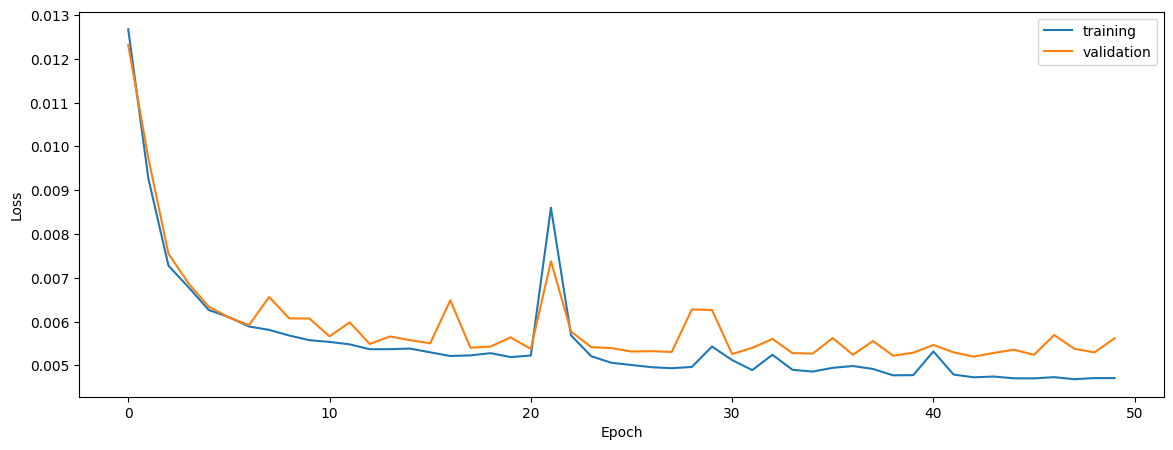

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7819611704630921
0.7904784033863452
0.7459367529876231


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7819611704630921
0.7904784033863452
0.7459367529876231


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7826218395813943
0.7883358663179856
0.7649070101266943


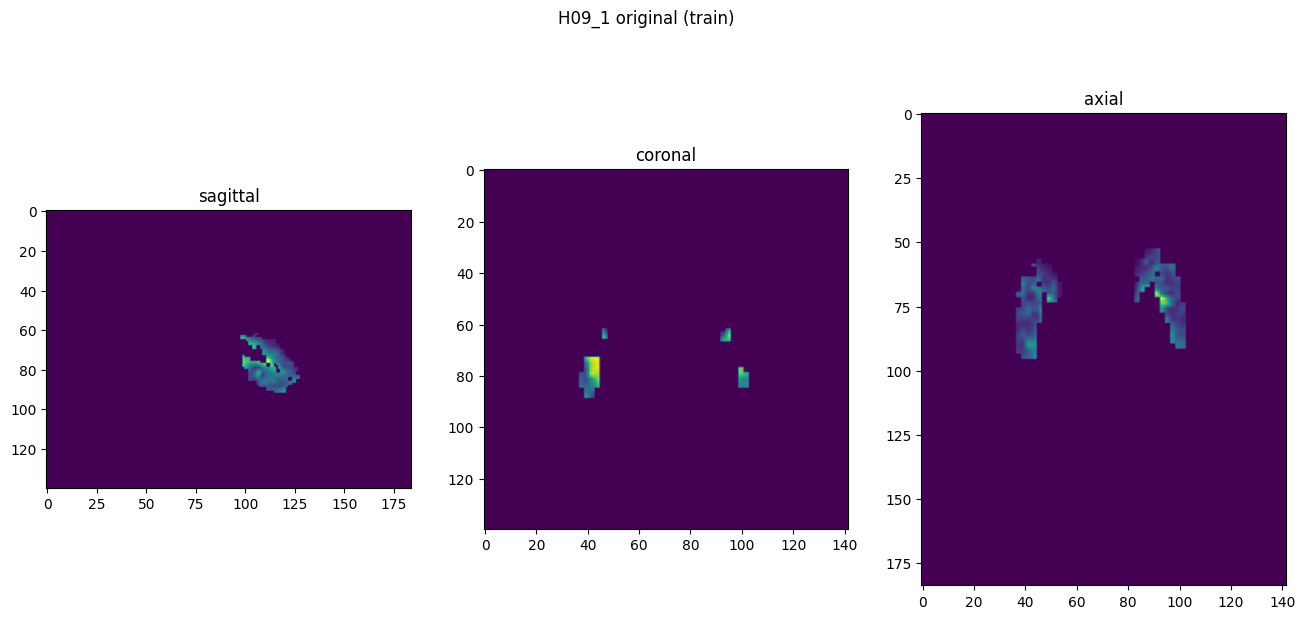

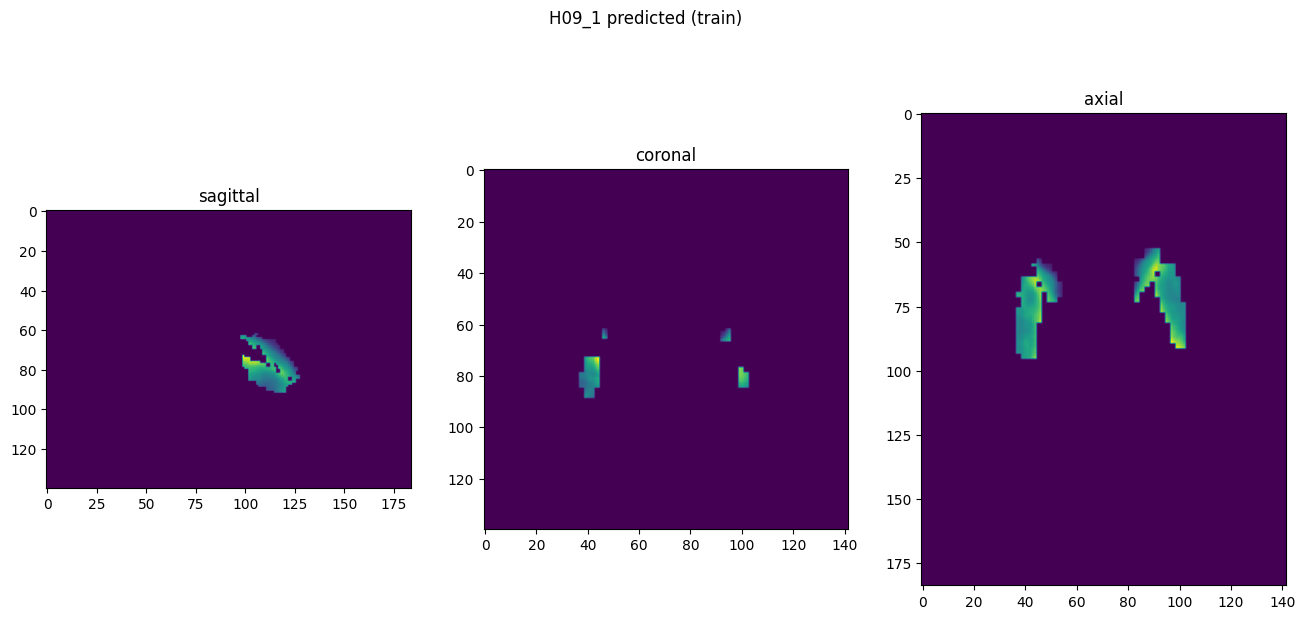

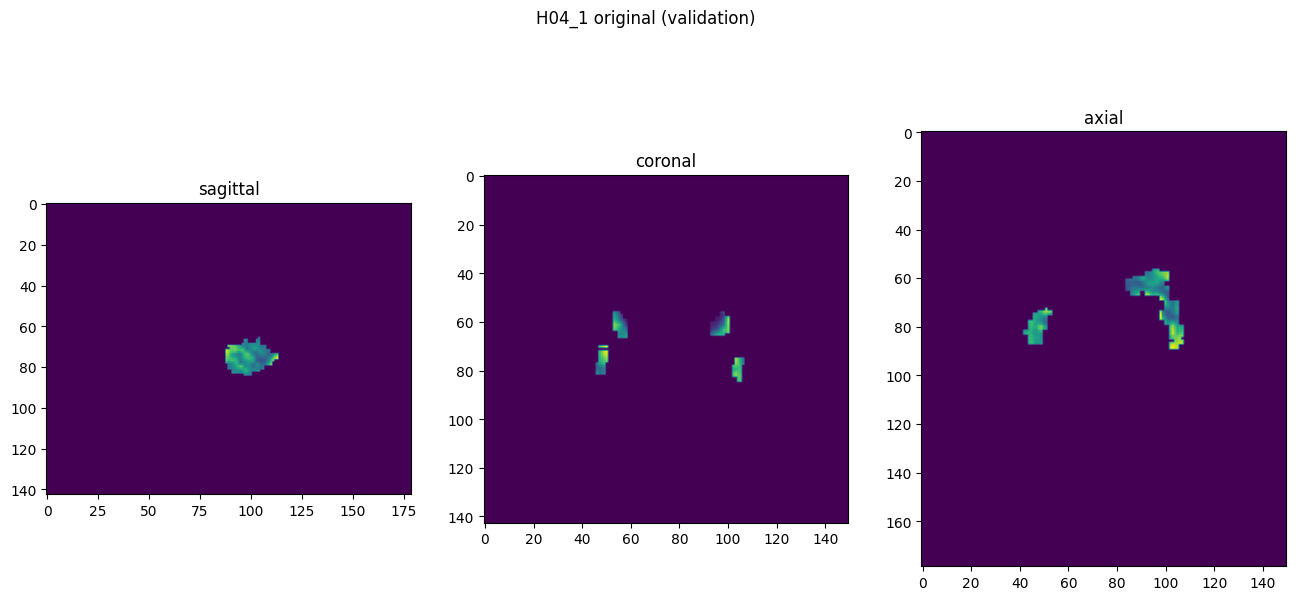

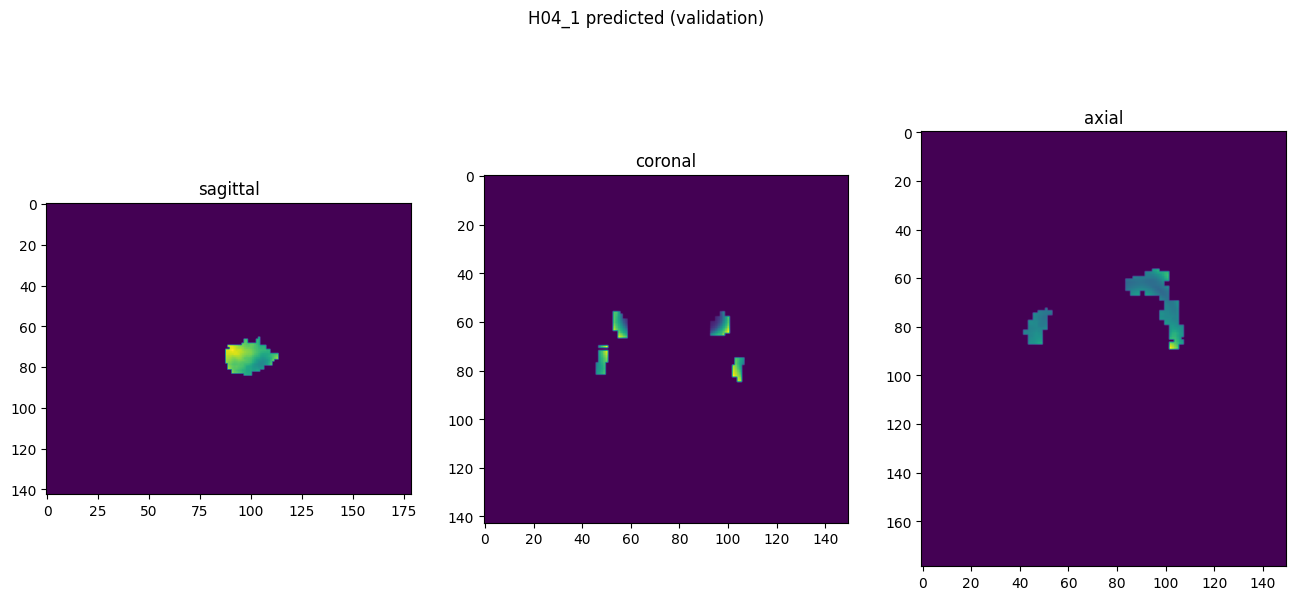

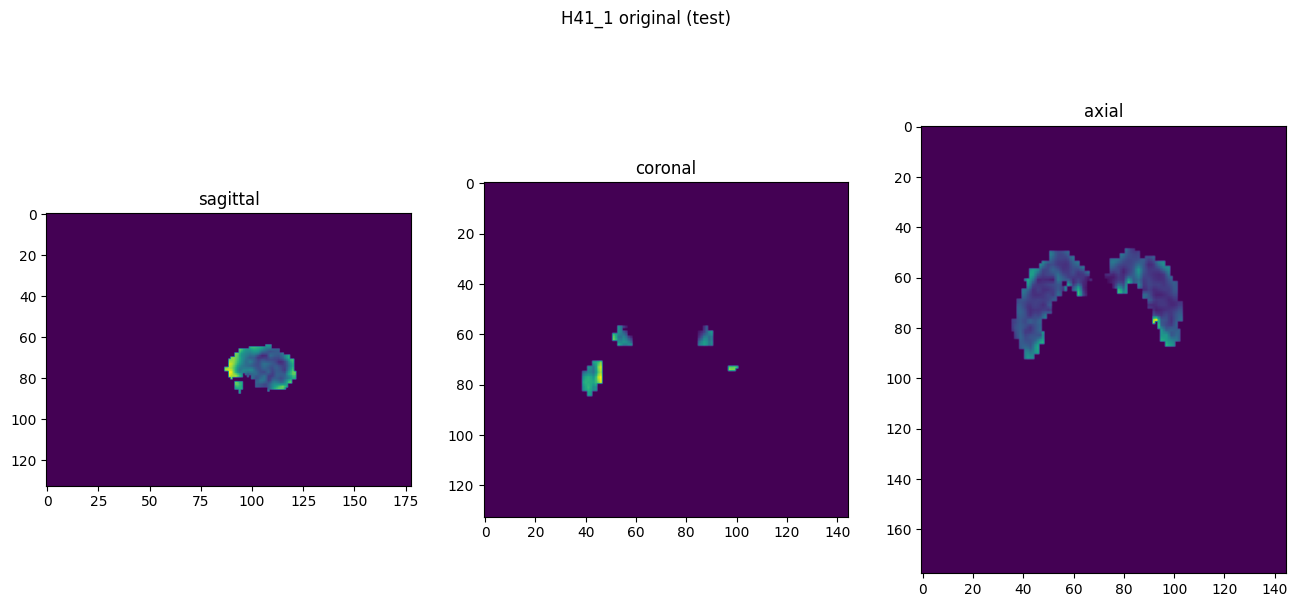

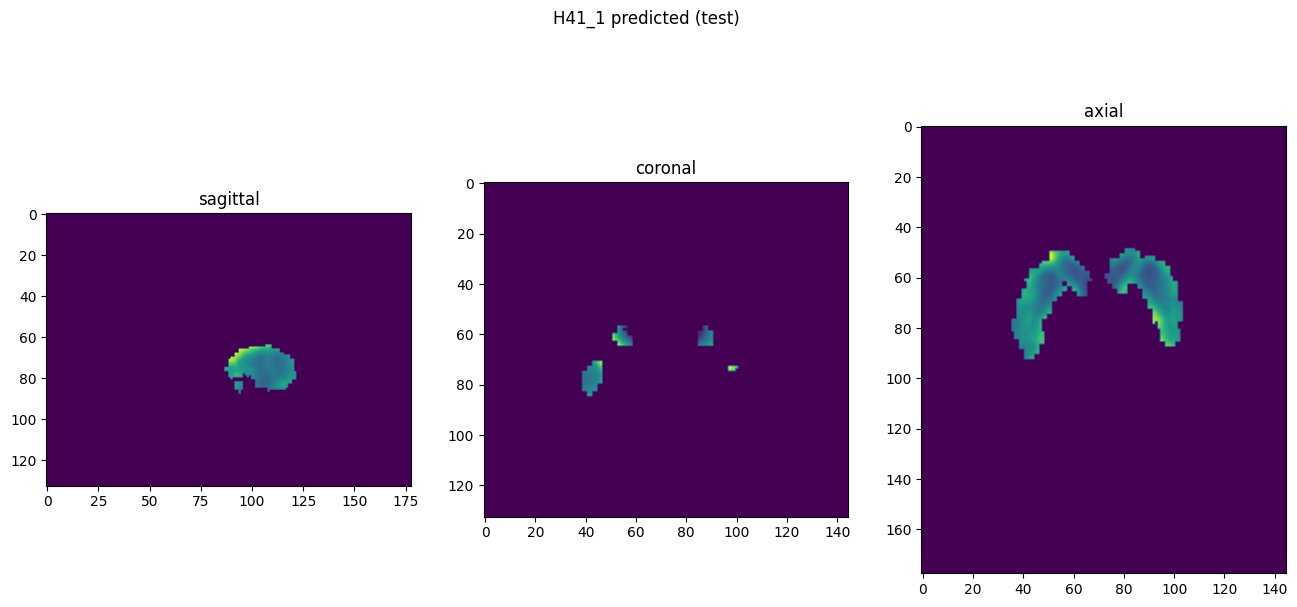

In [10]:
showResults(model, gen, threshold=None, background=False)